# Produção Energética e Sustentabilidade

### Descrição

A energia solar é uma das principais fontes de energias renováveis, desempenhando não só um papel fundamental na transição para fontes de energia limpa e renovável, mas também na promoção da sustentabilidade ambiental. Nesse contexto, além de ser crucial otimizar o uso da energia solar, a relação entre o gasto e a produção energética é essencial para permitir um planeamento eficaz do consumo energético e a integração harmoniosa de sistemas de energia solar em redes elétricas existentes.

Nesse sentido, a 6ª Edição da Competição ML @SBS/DAA consiste no desenvolvimento de modelos de Machine Learning capazes de prever, com precisão, a quantidade de energia elétrica, em kWh, gerada por painéis solares e injectada na rede eléctrica existente a cada hora do dia com base numa ampla gama de atributos, que vão desde dados meteorológicos e informações geográficas, ao histórico de gasto e produção energética.

Este é, portanto, um problema de previsão de energia com impacto significativo na eficiência energética, mas também na redução das emissões de gases com efeito estufa e na promoção da sustentabilidade. Com isso em consideração, foi colecionado um dataset que contém diversos dados referentes à produção energética de determinados painéis solares na cidade de Braga (o dataset cobre um período que vai desde setembro de 2021 até abril de 2023).

### Objetivo

O objetivo de cada grupo de trabalho passa por desenvolver o melhor modelo possível capaz de prever a quantidade de energia, em kWh, produzida por painéis solares e injectada, em redes elétricas existentes, a cada hora do dia.

O dataset utilizado nesta competição contém um conjunto de features sendo de destacar a feature Injeção na rede (kWh) . Esta feature indica, numa escala qualitativa (None, Low, Medium, High e Very_High), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal (i.e., numa determinada hora de um determinado dia). Se o valor desta feature for None, significa que não foi injectada nenhuma energia na rede (ou porque nada foi obtido dos painéis solares, ou porque toda a energia produzida pelos painéis foi consumida localmente). Um valor de Very_High implica a existência de uma quantidade muito alta de energia injectada na rede eléctrica naquele ponto temporal.

Para treino e tuning dos modelos de Machine Learning ser-vos-ão disponibilizados dois datasets com dados energéticos e dois datasets com dados meteorológicos. Tantos os datasets energéticos como os meteorológicos estão divididos por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Os grupos de trabalho poderão adicionar aos datasets qualquer atributo que achem relevante.

Para obtenção de scores na competição, os grupos de trabalho deverão prever, para cada registo do dataset de teste ("energia_202301-202304.csv"), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal, utilizando a escala None, Low, Medium, High e Very_High.

### Os dados

São disponibilizados dois tipos de datasets, i.e., um tipo com dados energéticos e outro tipo com dados meteorológicos. Além disso, cada tipo de dataset está dividido por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Em resumo, são disponibilizados quatro datasets para treino e tuning dos modelos de Machine Learning

Features dos Datasets de Energia

- **Data** - o timestamp associado ao registo, ao dia;
- **Hora** - a hora associada ao registo;
- **Normal (kWh)** - quantidade de energia eléctrica consumida, em kWh e proveniente da rede eléctrica, num período considerado normal em ciclos bi-horário diários (horas fora de vazio);
- **Horário Económico (kWh)** - quantidade de energia eléctrica consumida, em kWh e proveniente da rede eléctrica, num período considerado económico em ciclos bi-horário diários (horas de vazio);
- **Autoconsumo (kWh)** - quantidade de energia eléctrica consumida, em kWh, proveniente dos painéis solares;
- **Injeção na rede (kWh)** - quantidade de energia eléctrica injectada na rede eléctrica, em kWh, proveniente dos painéis solares.

Features dos Datasets Meteorológicos

- **dt** - o timestamp associado ao registo;
- **dt_iso** - a data associada ao registo, ao segundo;
- **city_name** - o local em causa;
- **temp** - temperatura em ºC;
- **feels_like** - sensação térmica em ºC;
- **temp_min** - temperatura mínima sentida em ºC;
- **temp_max** - temperatura máxima sentida em ºC;
- **pressure** - pressão atmosférica sentida em atm;
- **sea_level** - pressão atmosférica sentida ao nível do mar em atm;
- **grnd_level** - pressão atmosférica sentida à altitude local em atm;
- **humidity** - humidade em percentagem;
- **wind_speed** - velocidade do vento em metros por segundo;
- **rain_1h** - valor médio de precipitação;
- **clouds_all** - nível de nebulosidade em percentagem;
- **weather_description** - avaliação qualitativa do estado do tempo.


## Importar Bibliotecas

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Outras bibliotecas a importar mais tarde
%matplotlib inline

## Carregar os Datasets

In [73]:
energia2021 = pd.read_csv('datasets/energia_202109-202112.csv', encoding = "ISO-8859-1")
energia2022 = pd.read_csv('datasets/energia_202201-202212.csv', encoding = "ISO-8859-1")
energia2023 = pd.read_csv('datasets/energia_202301-202304.csv', encoding = "ISO-8859-1")

meteo2021 = pd.read_csv('datasets/meteo_202109-202112.csv')
meteo2022 = pd.read_csv('datasets/meteo_202201-202212.csv')
meteo2023 = pd.read_csv('datasets/meteo_202301-202304.csv')

Verificar as colunas de cada dataset

In [74]:
print(energia2021.columns)
print(energia2022.columns)
print(energia2023.columns)
print(meteo2021.columns)
print(meteo2022.columns)
print(meteo2023.columns)

Index(['Data', 'Hora', 'Normal (kWh)', 'Horï¿½rio Econï¿½mico (kWh)',
       'Autoconsumo (kWh)', 'Injeï¿½ï¿½o na rede (kWh)'],
      dtype='object')
Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)'],
      dtype='object')
Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level',

In [75]:
print(energia2021.info())
print()
print(energia2022.info())
print()
print(energia2023.info())
print()
print(meteo2021.info())
print()
print(meteo2022.info())
print()
print(meteo2023.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         2256 non-null   object 
 1   Hora                         2256 non-null   int64  
 2   Normal (kWh)                 2256 non-null   float64
 3   Horï¿½rio Econï¿½mico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)            2256 non-null   float64
 5   Injeï¿½ï¿½o na rede (kWh)    566 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     8760 non-null   object 
 1   Hora                     8760 non-null   int64  
 2   Normal (kWh)             8760 non

Conclusão: as colunas são as mesmas

Próximo passo: Concatenar os datasets

In [76]:
frames_energia = [energia2021, energia2022]
frames_meteo = [meteo2021, meteo2022]

energia = pd.concat(frames_energia)
meteo = pd.concat(frames_meteo)

meteo.rename(columns={'dt': 'Timestamp','dt_iso':'Data', 'city_name':'Nome da Cidade', 'temp':'Temperatura (ºC)', 'feels_like': 'Sensação Térmica (ºC)', 'temp_min': 'Temperatura Mínima (ºC)', 'temp_max': 'Temperatura Máxima (ºC)', 'pressure': 'Pressão Atmosférica (atm)', 'sea_level': 'Pressão atmosférica no nível do mar (atm)', 'grnd_level': 'Pressão atmosférica na altitude local (atm)', 'humidity': 'Humidade (%)', 'wind_speed': 'Velocidade do vento (m/s)', 'rain_1h': 'Valor médio de precipitação', 'clouds_all': 'Nível de nebulosidade (%)', 'weather_description': 'Avaliação qualitativa do estado do tempo'}, inplace=True)


Verificar o tamanho dos dados depois da concatenação, a presença de missing values e os tipos de dados

In [77]:
print(energia.info())
print()
print(meteo.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11016 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         11016 non-null  object 
 1   Hora                         11016 non-null  int64  
 2   Normal (kWh)                 11016 non-null  float64
 3   Horï¿½rio Econï¿½mico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)            11016 non-null  float64
 5   Injeï¿½ï¿½o na rede (kWh)    566 non-null    object 
 6   Horário Económico (kWh)      8760 non-null   float64
 7   Injeção na rede (kWh)        2673 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 774.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----

In [78]:
meteo

,Timestamp,Data,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1672513200,2022-12-31 19:00:00 +0000 UTC,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,1672516800,2022-12-31 20:00:00 +0000 UTC,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,1672520400,2022-12-31 21:00:00 +0000 UTC,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,1672524000,2022-12-31 22:00:00 +0000 UTC,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [79]:
energia

,Data,Hora,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.000,0.0,0.0,NaN,NaN,NaN
1,2021-09-29,1,0.000,0.0,0.0,NaN,NaN,NaN
2,2021-09-29,2,0.000,0.0,0.0,NaN,NaN,NaN
3,2021-09-29,3,0.000,0.0,0.0,NaN,NaN,NaN
4,2021-09-29,4,0.000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1.693,NaN,0.0,NaN,0.000,NaN
8756,2022-12-31,20,1.327,NaN,0.0,NaN,0.000,NaN
8757,2022-12-31,21,0.757,NaN,0.0,NaN,0.000,NaN
8758,2022-12-31,22,0.000,NaN,0.0,NaN,0.675,NaN


Juntar num único dataset. Precisamos de agrupar os dados metereológicos às medições de energia correspondentes.
Agrupar por Data e Hora.

In [80]:
meteo['Data'] = pd.to_datetime(meteo['Data'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC
meteo.head()

,Timestamp,Data,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,1630454400,2021-09-01 00:00:00,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [81]:

energia['Data'] = pd.to_datetime(energia.apply(lambda row: f"{row['Data']} {row['Hora']}", axis=1), format='%Y-%m-%d %H', errors='coerce') 
energia.drop('Hora', axis=1, inplace=True)
energia.head()

,Data,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh)
0,2021-09-29 00:00:00,0.0,0.0,0.0,NaN,NaN,NaN
1,2021-09-29 01:00:00,0.0,0.0,0.0,NaN,NaN,NaN
2,2021-09-29 02:00:00,0.0,0.0,0.0,NaN,NaN,NaN
3,2021-09-29 03:00:00,0.0,0.0,0.0,NaN,NaN,NaN
4,2021-09-29 04:00:00,0.0,0.0,0.0,NaN,NaN,NaN


### Merge aos dois datasets

In [82]:
data = pd.merge(energia, meteo, how = 'left', on = 'Data')
data

,Data,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Timestamp,Nome da Cidade,Temperatura (ºC),...,Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,2021-09-29 00:00:00,0.000,0.0,0.0,NaN,NaN,NaN,1632873600,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29 01:00:00,0.000,0.0,0.0,NaN,NaN,NaN,1632877200,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29 02:00:00,0.000,0.0,0.0,NaN,NaN,NaN,1632880800,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29 03:00:00,0.000,0.0,0.0,NaN,NaN,NaN,1632884400,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29 04:00:00,0.000,0.0,0.0,NaN,NaN,NaN,1632888000,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31 19:00:00,1.693,NaN,0.0,NaN,0.000,NaN,1672513200,local,15.70,...,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
11012,2022-12-31 20:00:00,1.327,NaN,0.0,NaN,0.000,NaN,1672516800,local,15.55,...,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
11013,2022-12-31 21:00:00,0.757,NaN,0.0,NaN,0.000,NaN,1672520400,local,13.45,...,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
11014,2022-12-31 22:00:00,0.000,NaN,0.0,NaN,0.675,NaN,1672524000,local,12.93,...,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


### Verificação da coluna Timestamp e Nome da Cidade

In [83]:
data['Timestamp'].value_counts()

Timestamp
1632873600    1
1659322800    1
1659294000    1
1659297600    1
1659301200    1
             ..
1646096400    1
1646100000    1
1646103600    1
1646107200    1
1672527600    1
Name: count, Length: 11016, dtype: int64

In [84]:
data['Nome da Cidade'].value_counts()

Nome da Cidade
local    11016
Name: count, dtype: int64

In [85]:
data.drop(['Timestamp', 'Nome da Cidade'], axis=1, inplace=True)

In [86]:
data

,Data,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,2021-09-29 00:00:00,0.000,0.0,0.0,NaN,NaN,NaN,13.97,13.54,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29 01:00:00,0.000,0.0,0.0,NaN,NaN,NaN,13.48,13.02,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29 02:00:00,0.000,0.0,0.0,NaN,NaN,NaN,12.93,12.47,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29 03:00:00,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.15,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29 04:00:00,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.17,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31 19:00:00,1.693,NaN,0.0,NaN,0.000,NaN,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
11012,2022-12-31 20:00:00,1.327,NaN,0.0,NaN,0.000,NaN,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
11013,2022-12-31 21:00:00,0.757,NaN,0.0,NaN,0.000,NaN,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
11014,2022-12-31 22:00:00,0.000,NaN,0.0,NaN,0.675,NaN,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


Divisão da coluna Data

In [87]:
data['Year'] = data['Data'].dt.year
data['Month'] = data['Data'].dt.month
data['Day'] = data['Data'].dt.day
data['Hour'] = data['Data'].dt.hour
data['Minute'] = data['Data'].dt.minute
data['Seconds'] = data['Data'].dt.second

data.drop(['Data'], axis=1, inplace=True)

In [88]:
data

,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),...,Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour,Minute,Seconds
0,0.000,0.0,0.0,NaN,NaN,NaN,13.97,13.54,11.45,14.04,...,1.96,NaN,87,overcast clouds,2021,9,29,0,0,0
1,0.000,0.0,0.0,NaN,NaN,NaN,13.48,13.02,13.43,13.90,...,1.83,NaN,91,overcast clouds,2021,9,29,1,0,0
2,0.000,0.0,0.0,NaN,NaN,NaN,12.93,12.47,12.72,13.43,...,1.96,NaN,93,overcast clouds,2021,9,29,2,0,0
3,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.15,10.34,12.93,...,1.85,NaN,95,overcast clouds,2021,9,29,3,0,0
4,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.17,9.79,12.93,...,1.83,NaN,93,overcast clouds,2021,9,29,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,NaN,0.0,NaN,0.000,NaN,15.70,15.57,15.57,15.72,...,5.56,3.58,100,moderate rain,2022,12,31,19,0,0
11012,1.327,NaN,0.0,NaN,0.000,NaN,15.55,15.43,12.72,15.70,...,4.47,4.20,100,heavy intensity rain,2022,12,31,20,0,0
11013,0.757,NaN,0.0,NaN,0.000,NaN,13.45,13.28,12.23,13.99,...,3.29,4.23,100,heavy intensity rain,2022,12,31,21,0,0
11014,0.000,NaN,0.0,NaN,0.675,NaN,12.93,12.73,12.23,13.43,...,1.49,3.90,100,moderate rain,2022,12,31,22,0,0


In [89]:
print(data['Minute'].value_counts())
print(data['Seconds'].value_counts())

Minute
0    11016
Name: count, dtype: int64
Seconds
0    11016
Name: count, dtype: int64


In [90]:
data.drop(['Minute', 'Seconds'], axis=1, inplace=True)

In [91]:
data

,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),...,Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.0,0.0,NaN,NaN,NaN,13.97,13.54,11.45,14.04,...,NaN,81,1.96,NaN,87,overcast clouds,2021,9,29,0
1,0.000,0.0,0.0,NaN,NaN,NaN,13.48,13.02,13.43,13.90,...,NaN,82,1.83,NaN,91,overcast clouds,2021,9,29,1
2,0.000,0.0,0.0,NaN,NaN,NaN,12.93,12.47,12.72,13.43,...,NaN,84,1.96,NaN,93,overcast clouds,2021,9,29,2
3,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.15,10.34,12.93,...,NaN,85,1.85,NaN,95,overcast clouds,2021,9,29,3
4,0.000,0.0,0.0,NaN,NaN,NaN,12.61,12.17,9.79,12.93,...,NaN,86,1.83,NaN,93,overcast clouds,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,NaN,0.0,NaN,0.000,NaN,15.70,15.57,15.57,15.72,...,NaN,86,5.56,3.58,100,moderate rain,2022,12,31,19
11012,1.327,NaN,0.0,NaN,0.000,NaN,15.55,15.43,12.72,15.70,...,NaN,87,4.47,4.20,100,heavy intensity rain,2022,12,31,20
11013,0.757,NaN,0.0,NaN,0.000,NaN,13.45,13.28,12.23,13.99,...,NaN,93,3.29,4.23,100,heavy intensity rain,2022,12,31,21
11014,0.000,NaN,0.0,NaN,0.675,NaN,12.93,12.73,12.23,13.43,...,NaN,94,1.49,3.90,100,moderate rain,2022,12,31,22


### Preparação e Transformação dos Dados

Verificar missing values

<Axes: >

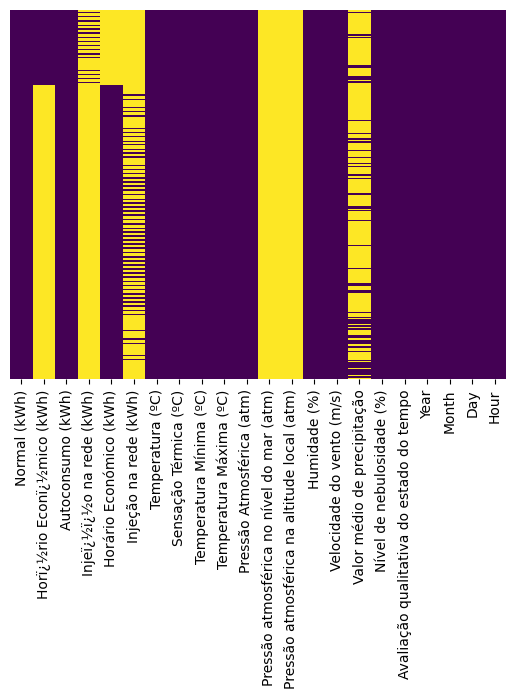

In [92]:
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Retirar colunas 'Pressão atmosférica no nível do mar(atm)' e 'Pressão atmosférica na altitude local(atm)'

<Axes: >

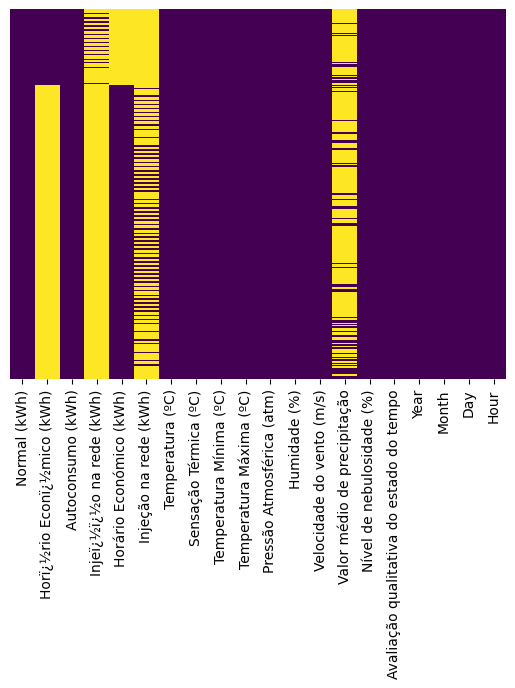

In [93]:
data.drop(['Pressão atmosférica no nível do mar (atm)', 'Pressão atmosférica na altitude local (atm)'], axis=1, inplace=True)
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Tratamento da coluna 'Valor médio de precipitação'

In [94]:
data['Valor médio de precipitação'].value_counts()

Valor médio de precipitação
0.12    69
0.16    57
0.15    54
0.14    54
0.11    51
        ..
6.36     1
3.54     1
3.89     1
3.65     1
4.07     1
Name: count, Length: 367, dtype: int64

<Axes: >

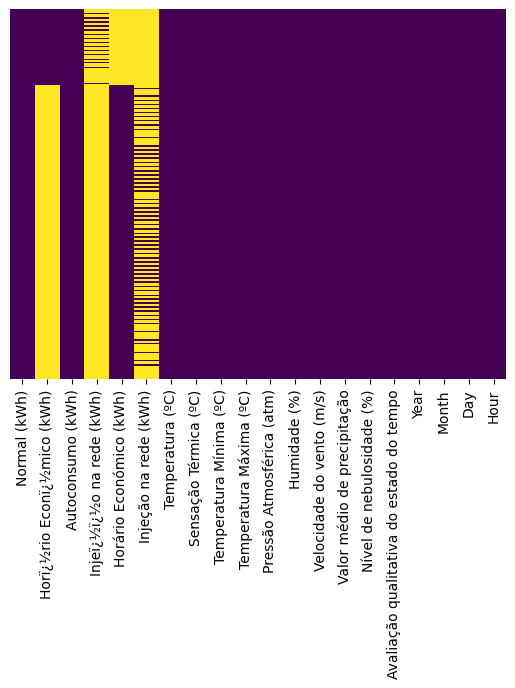

In [95]:
data['Valor médio de precipitação'] = data['Valor médio de precipitação'].fillna(0)
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Tratamento da coluna 'Injeção na rede(kWh)'

In [96]:
data['Injeção na rede (kWh)'].value_counts()

Injeção na rede (kWh)
Medium       916
High         896
Very High    538
Low          323
Name: count, dtype: int64

<Axes: >

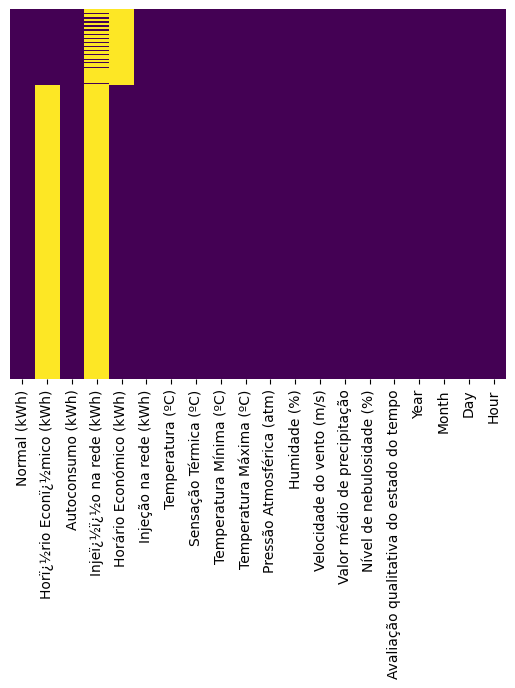

In [97]:
data['Injeção na rede (kWh)'] = data['Injeção na rede (kWh)'].fillna('None')
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [98]:
data

,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.0,0.0,NaN,NaN,None,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,overcast clouds,2021,9,29,0
1,0.000,0.0,0.0,NaN,NaN,None,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,overcast clouds,2021,9,29,1
2,0.000,0.0,0.0,NaN,NaN,None,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,overcast clouds,2021,9,29,2
3,0.000,0.0,0.0,NaN,NaN,None,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,overcast clouds,2021,9,29,3
4,0.000,0.0,0.0,NaN,NaN,None,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,overcast clouds,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,NaN,0.0,NaN,0.000,None,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,2022,12,31,19
11012,1.327,NaN,0.0,NaN,0.000,None,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,2022,12,31,20
11013,0.757,NaN,0.0,NaN,0.000,None,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,2022,12,31,21
11014,0.000,NaN,0.0,NaN,0.675,None,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,2022,12,31,22


### Analisar os dados

Analisar os valores para a coluna temp

In [99]:
data['Temperatura (ºC)'].value_counts()

Temperatura (ºC)
14.59    61
15.70    55
16.82    50
12.92    46
16.81    44
         ..
4.27      1
9.72      1
8.01      1
28.55     1
15.43     1
Name: count, Length: 2382, dtype: int64

Histograma 

<Axes: >

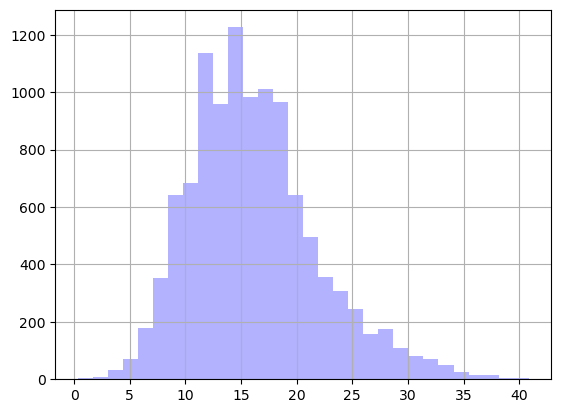

In [100]:
data['Temperatura (ºC)'].hist(bins=30, color='blue', alpha=0.3)

In [101]:
data['Avaliação qualitativa do estado do tempo'].value_counts()

Avaliação qualitativa do estado do tempo
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64

In [102]:
by_temp = data['Temperatura (ºC)'].groupby(data['Avaliação qualitativa do estado do tempo'])
print(by_temp.count())
print()
print(by_temp.mean())

Avaliação qualitativa do estado do tempo
broken clouds           1413
few clouds               731
heavy intensity rain      60
light rain              1662
moderate rain            562
overcast clouds         2430
scattered clouds        1148
sky is clear            3010
Name: Temperatura (ºC), dtype: int64

Avaliação qualitativa do estado do tempo
broken clouds           16.437657
few clouds              16.522763
heavy intensity rain    16.244333
light rain              14.994771
moderate rain           15.027740
overcast clouds         15.416708
scattered clouds        16.949408
sky is clear            17.177807
Name: Temperatura (ºC), dtype: float64


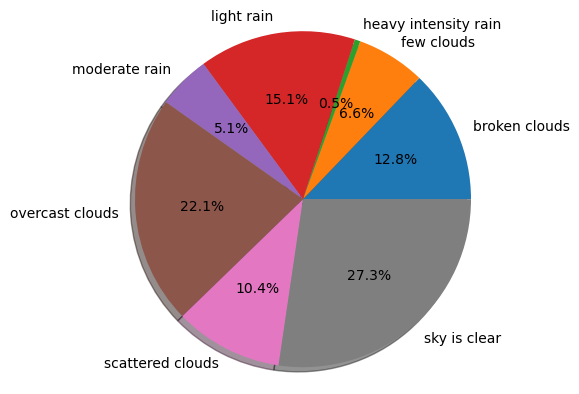

In [103]:
labels = data['Avaliação qualitativa do estado do tempo'].astype('category').cat.categories.tolist()
counts = data['Avaliação qualitativa do estado do tempo'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

Histograma referente à variável 'Injeção na Rede'

<Axes: >

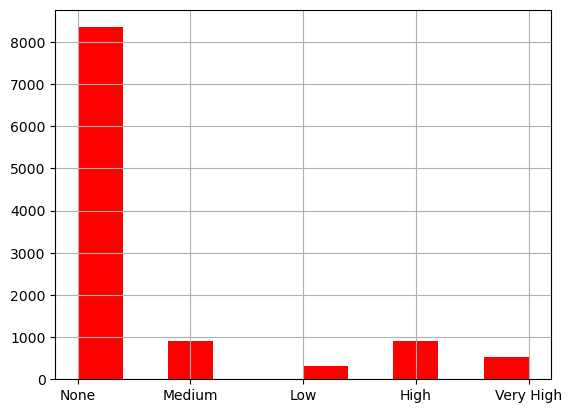

In [104]:
data['Injeção na rede (kWh)'].hist(color='red')

Método de Pearson

<Axes: >

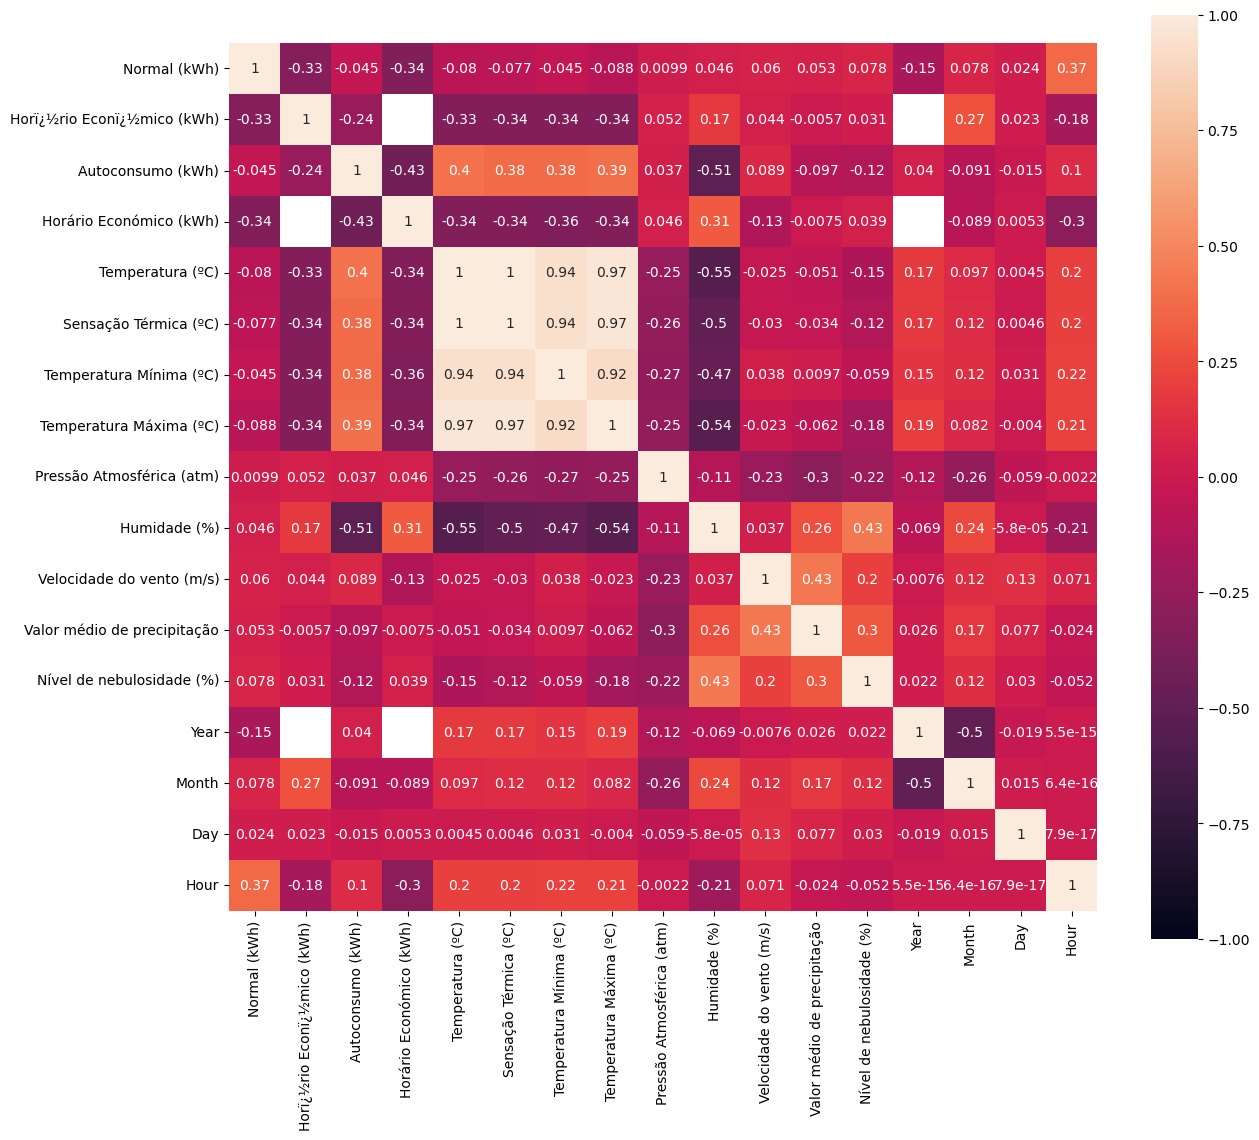

In [105]:
# Pearson Method
corr_matrix = data.corr(method='pearson', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

Método de Spearman

<Axes: >

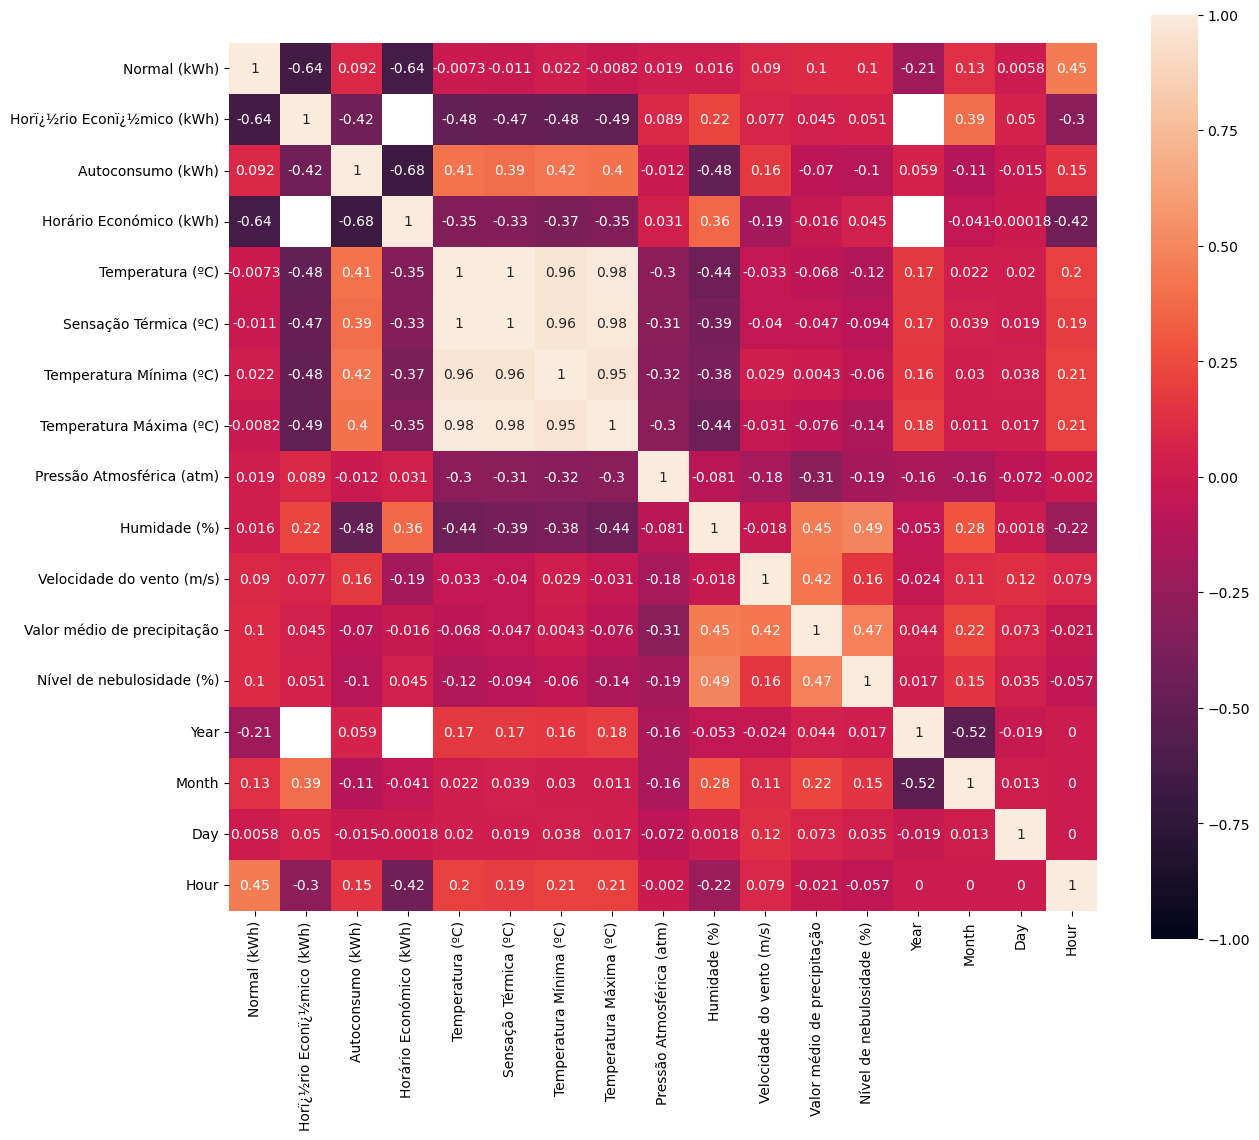

In [106]:
# Spearman method
corr_matrix = data.corr(method='spearman', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

Método de Kendall

<Axes: >

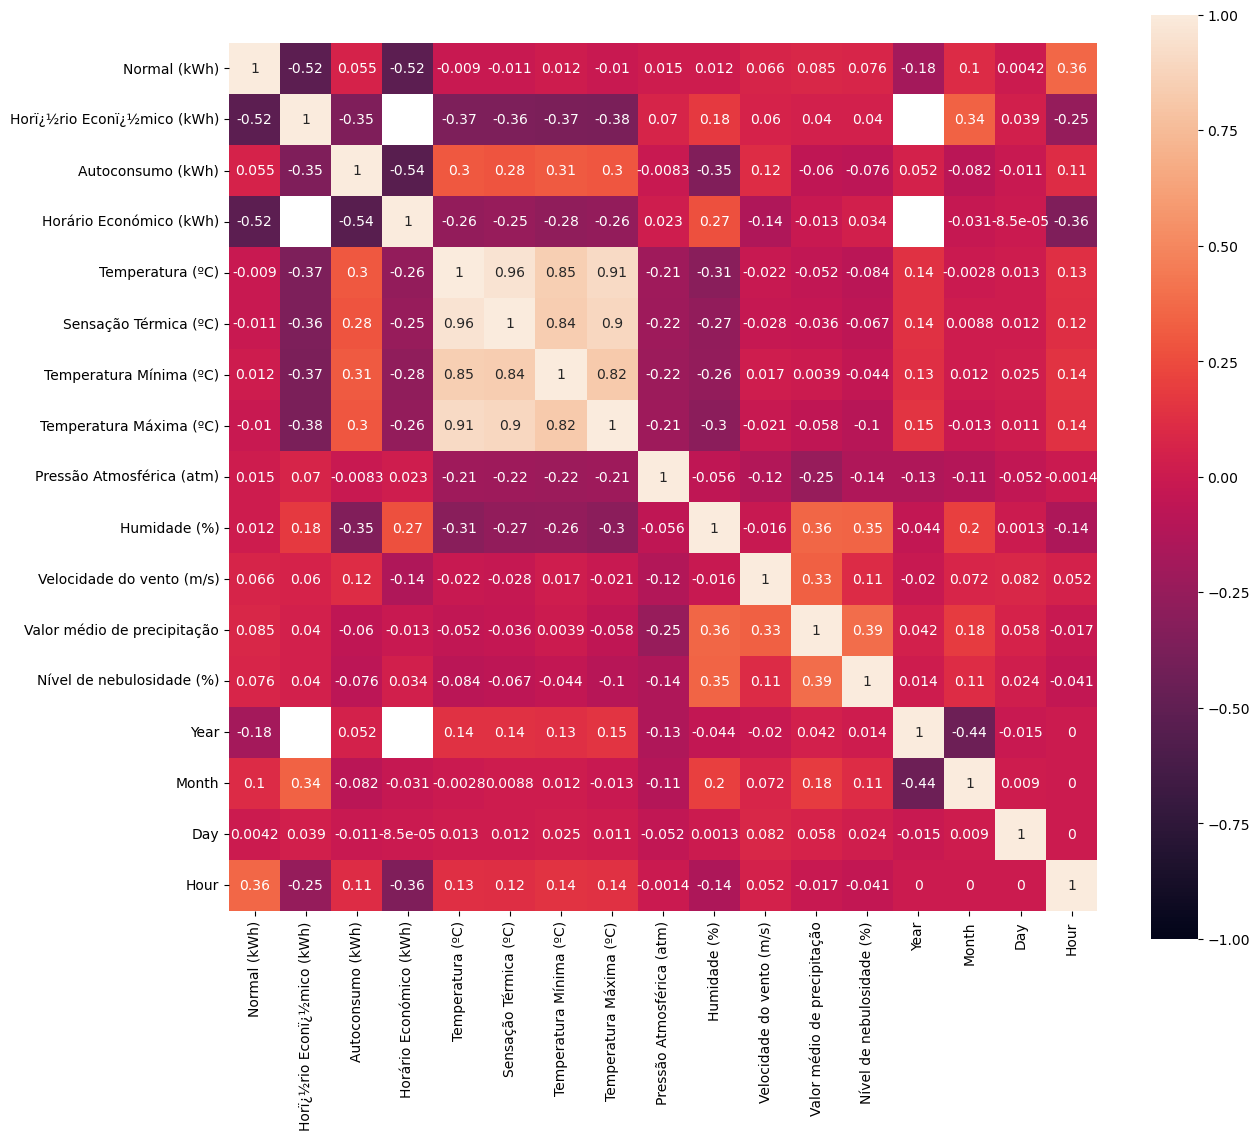

In [107]:
# Kendall method
corr_matrix = data.corr(method='kendall', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

## Outliers

Dançabilidade

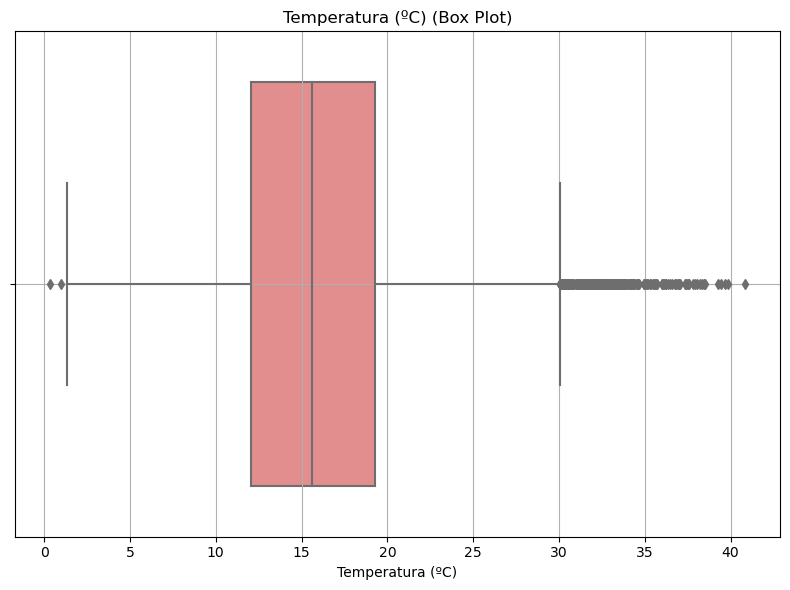

In [108]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Temperatura (ºC)'], color='lightcoral')
    
plt.title('Temperatura (ºC) (Box Plot)')
plt.xlabel('Temperatura (ºC)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

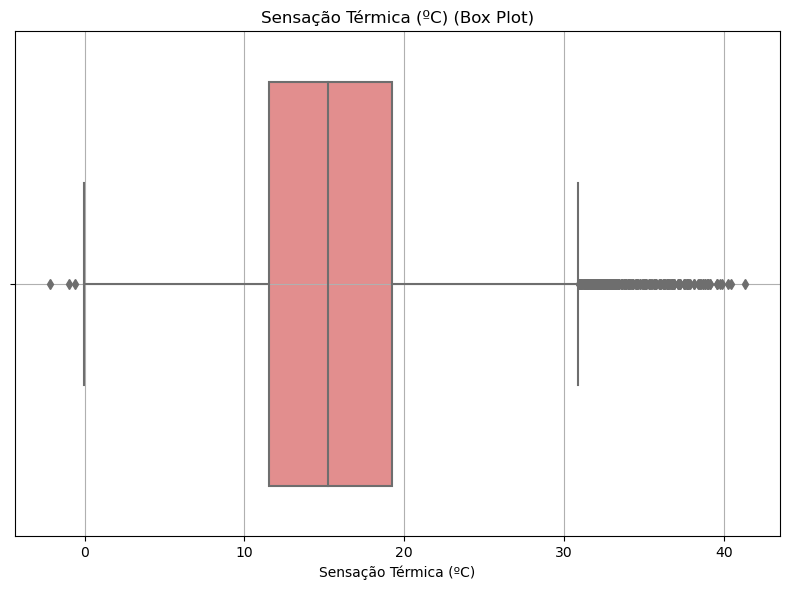

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Sensação Térmica (ºC)'], color='lightcoral')
    
plt.title('Sensação Térmica (ºC) (Box Plot)')
plt.xlabel('Sensação Térmica (ºC)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

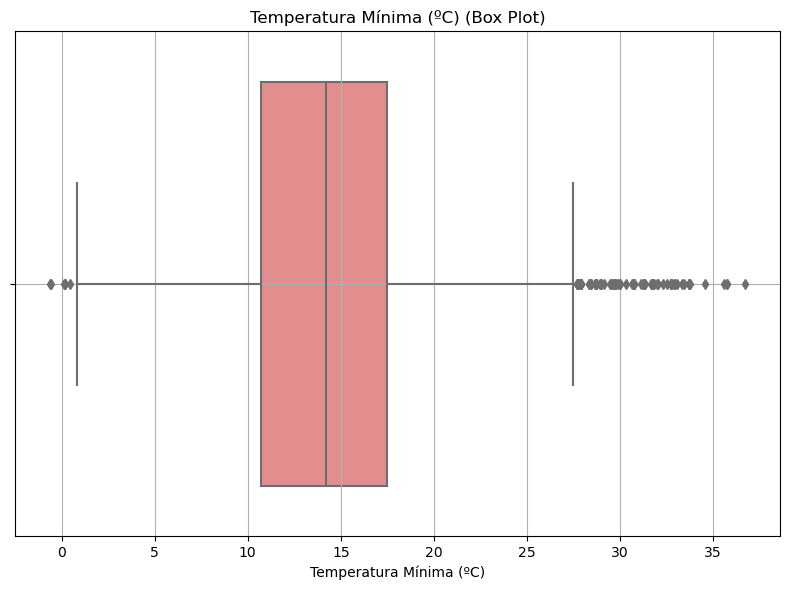

In [110]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Temperatura Mínima (ºC)'], color='lightcoral')
    
plt.title('Temperatura Mínima (ºC) (Box Plot)')
plt.xlabel('Temperatura Mínima (ºC)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

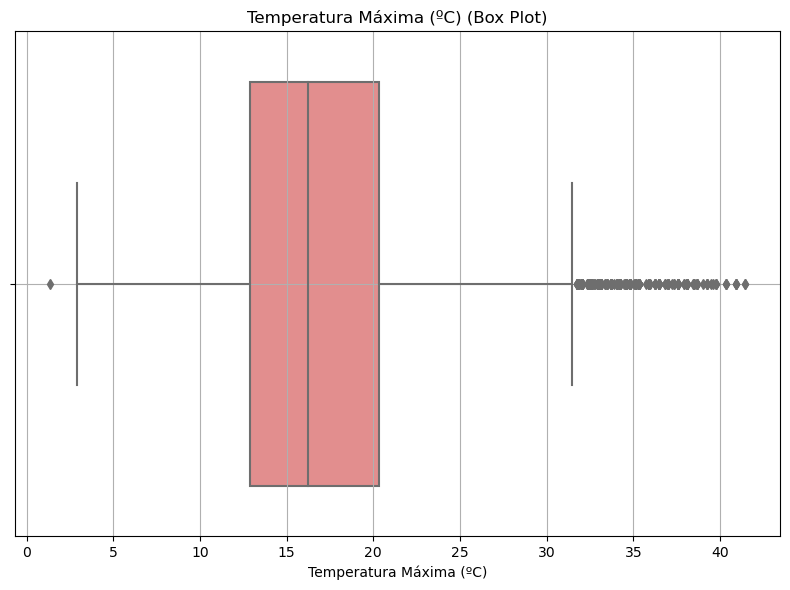

In [111]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Temperatura Máxima (ºC)'], color='lightcoral')
    
plt.title('Temperatura Máxima (ºC) (Box Plot)')
plt.xlabel('Temperatura Máxima (ºC)')
    
plt.grid(True)
plt.tight_layout()
plt.show()



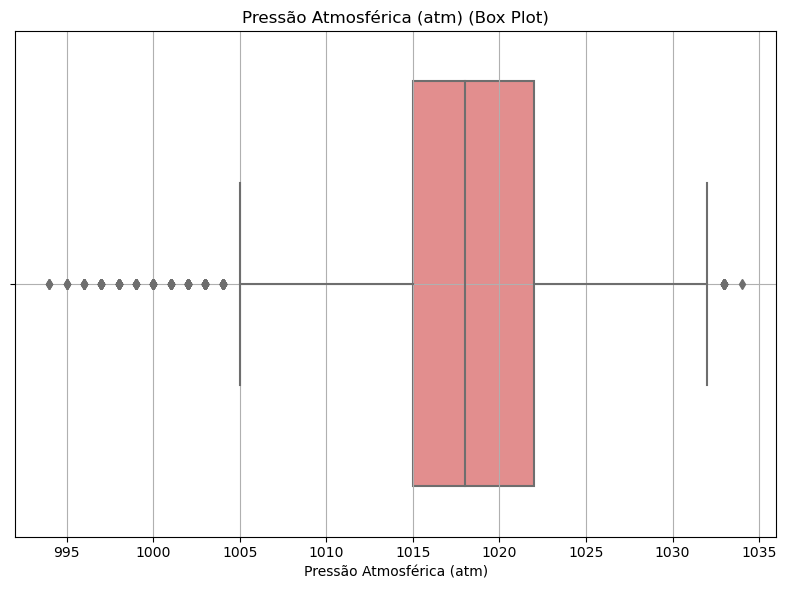

In [112]:

plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Pressão Atmosférica (atm)'], color='lightcoral')
    
plt.title('Pressão Atmosférica (atm) (Box Plot)')
plt.xlabel('Pressão Atmosférica (atm)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

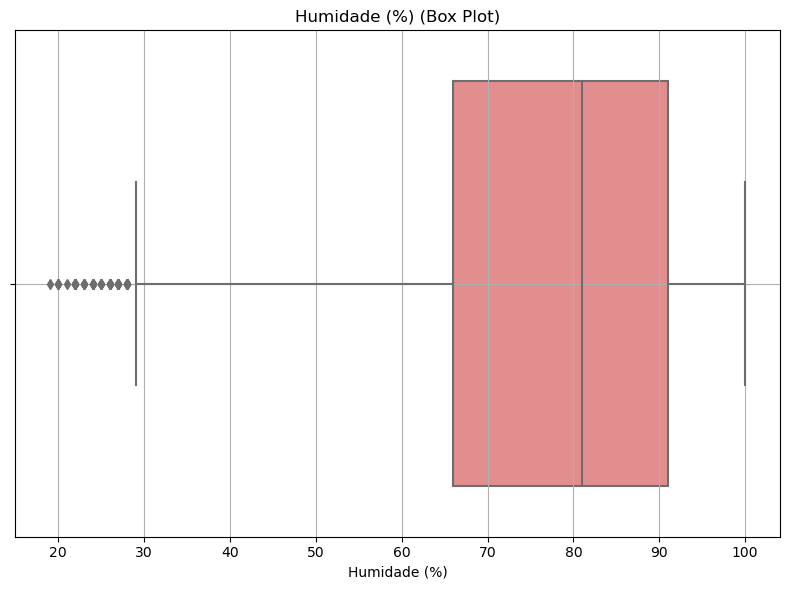

In [113]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Humidade (%)'], color='lightcoral')
    
plt.title('Humidade (%) (Box Plot)')
plt.xlabel('Humidade (%)')
    
plt.grid(True)
plt.tight_layout()
plt.show()



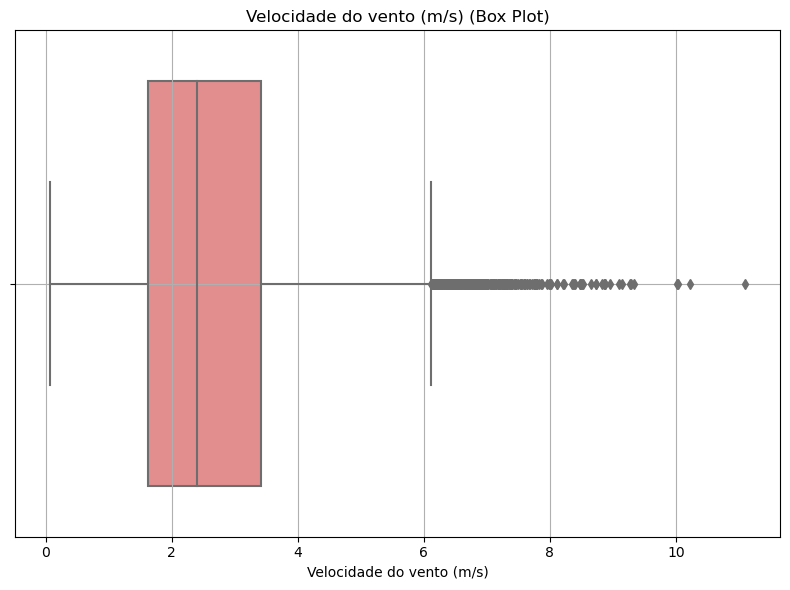

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Velocidade do vento (m/s)'], color='lightcoral')
    
plt.title('Velocidade do vento (m/s) (Box Plot)')
plt.xlabel('Velocidade do vento (m/s)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

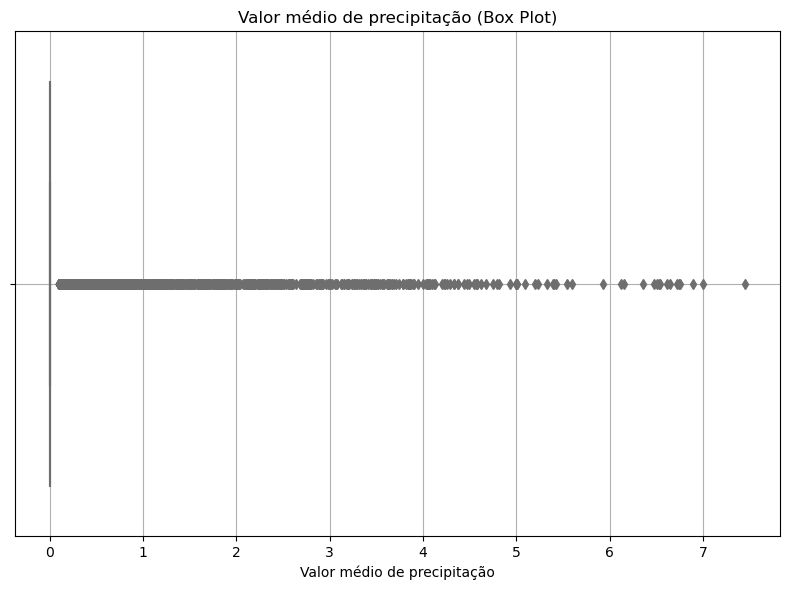

In [115]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Valor médio de precipitação'], color='lightcoral')
    
plt.title('Valor médio de precipitação (Box Plot)')
plt.xlabel('Valor médio de precipitação')
    
plt.grid(True)
plt.tight_layout()
plt.show()

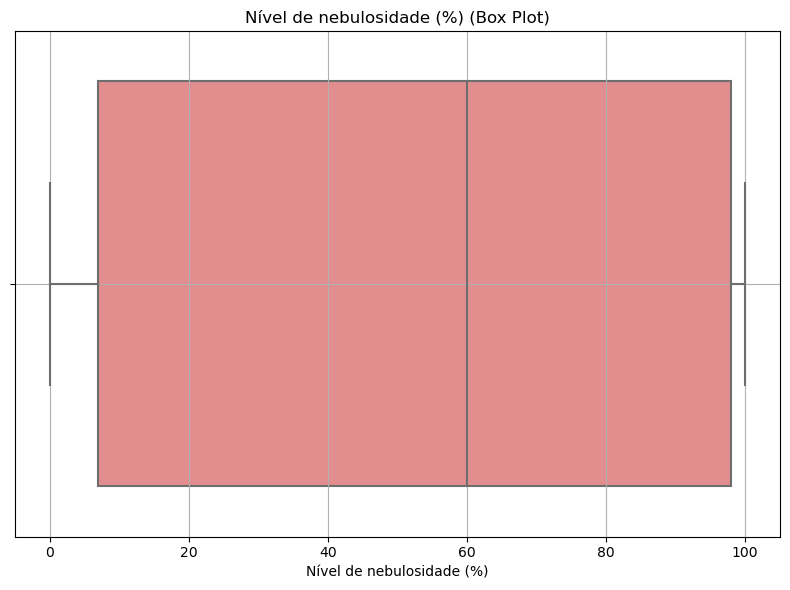

In [116]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Nível de nebulosidade (%)'], color='lightcoral')
    
plt.title('Nível de nebulosidade (%) (Box Plot)')
plt.xlabel('Nível de nebulosidade (%)')
    
plt.grid(True)
plt.tight_layout()
plt.show()



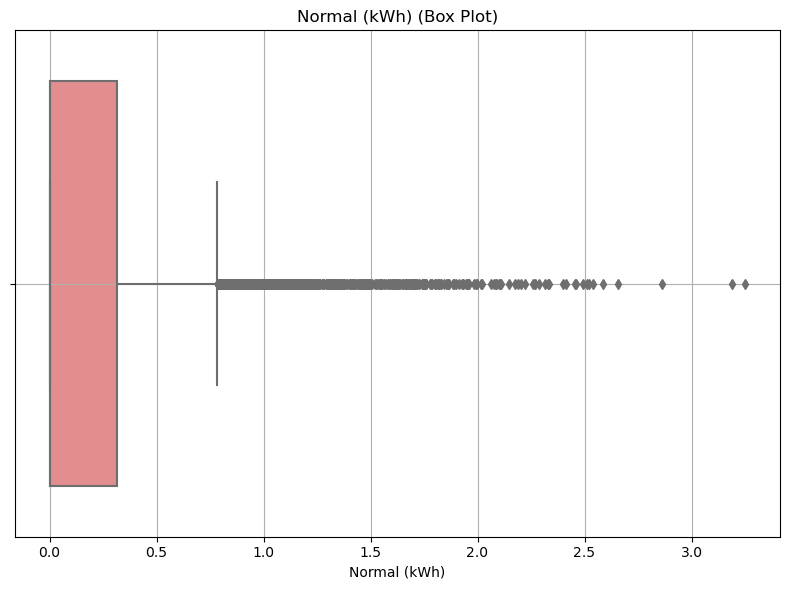

In [117]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Normal (kWh)'], color='lightcoral')
    
plt.title('Normal (kWh) (Box Plot)')
plt.xlabel('Normal (kWh)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

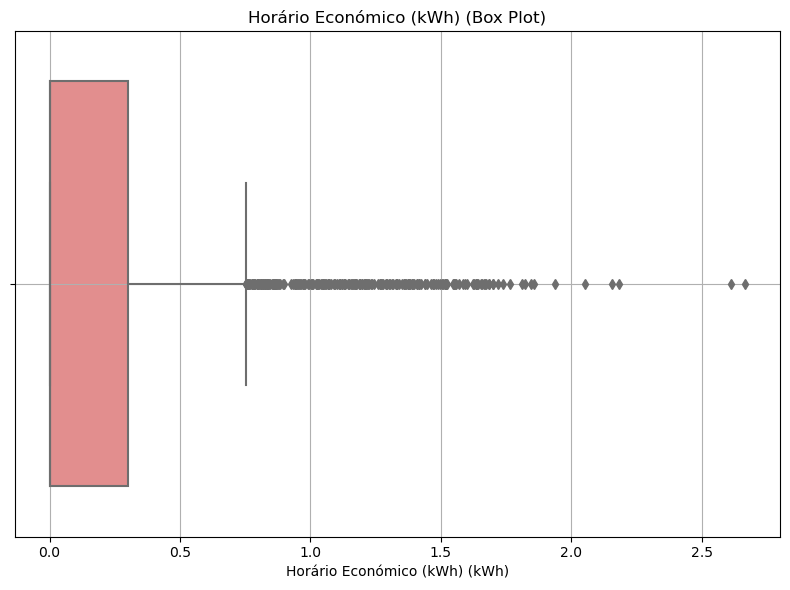

In [118]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Horário Económico (kWh)'], color='lightcoral')
    
plt.title('Horário Económico (kWh) (Box Plot)')
plt.xlabel('Horário Económico (kWh) (kWh)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

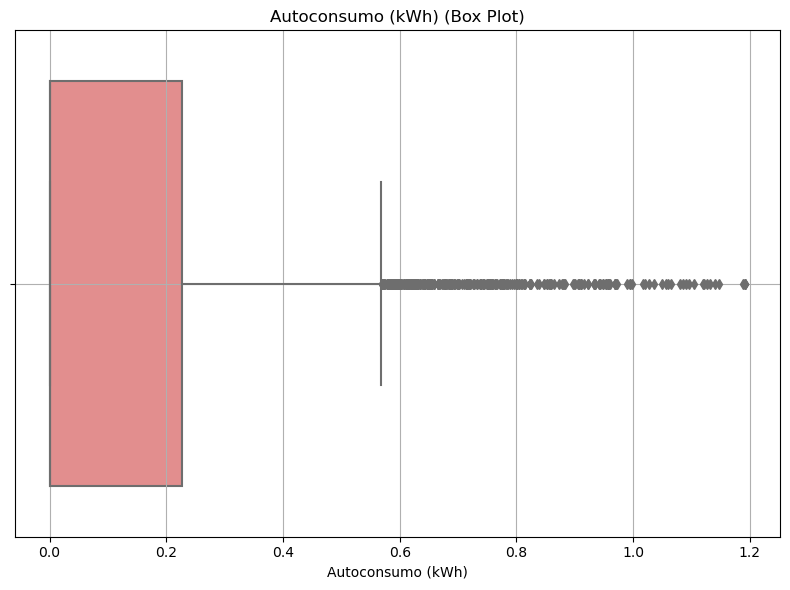

In [119]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Autoconsumo (kWh)'], color='lightcoral')
    
plt.title('Autoconsumo (kWh) (Box Plot)')
plt.xlabel('Autoconsumo (kWh)')
    
plt.grid(True)
plt.tight_layout()
plt.show()

### Análise multivariada

Analisar as relações entre múltiplas variáveis

In [120]:
#sns.pairplot(data)

In [121]:
mapeamento = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}

# Substituir os valores no DataFrame
data['Injeção na rede (kWh)'] = data['Injeção na rede (kWh)'].replace(mapeamento)

data['Injeção na rede (kWh)'].value_counts()

Injeção na rede (kWh)
0    8343
2     916
3     896
4     538
1     323
Name: count, dtype: int64

In [122]:
data['Avaliação qualitativa do estado do tempo'].value_counts()

Avaliação qualitativa do estado do tempo
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64

In [123]:
mapeamento = {'heavy intensity rain': 0, 'moderate rain': 1, 'light rain': 2, 'overcast clouds': 3, 'broken clouds': 4, 'scattered clouds': 5, 'few clouds': 6, 'sky is clear': 7}

# Substituir os valores no DataFrame
data['Avaliação qualitativa do estado do tempo'] = data['Avaliação qualitativa do estado do tempo'].replace(mapeamento)

In [124]:
data

,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.0,0.0,NaN,NaN,0,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,3,2021,9,29,0
1,0.000,0.0,0.0,NaN,NaN,0,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,3,2021,9,29,1
2,0.000,0.0,0.0,NaN,NaN,0,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,3,2021,9,29,2
3,0.000,0.0,0.0,NaN,NaN,0,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,3,2021,9,29,3
4,0.000,0.0,0.0,NaN,NaN,0,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,3,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,NaN,0.0,NaN,0.000,0,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,1,2022,12,31,19
11012,1.327,NaN,0.0,NaN,0.000,0,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,0,2022,12,31,20
11013,0.757,NaN,0.0,NaN,0.000,0,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,0,2022,12,31,21
11014,0.000,NaN,0.0,NaN,0.675,0,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,1,2022,12,31,22


<Axes: >

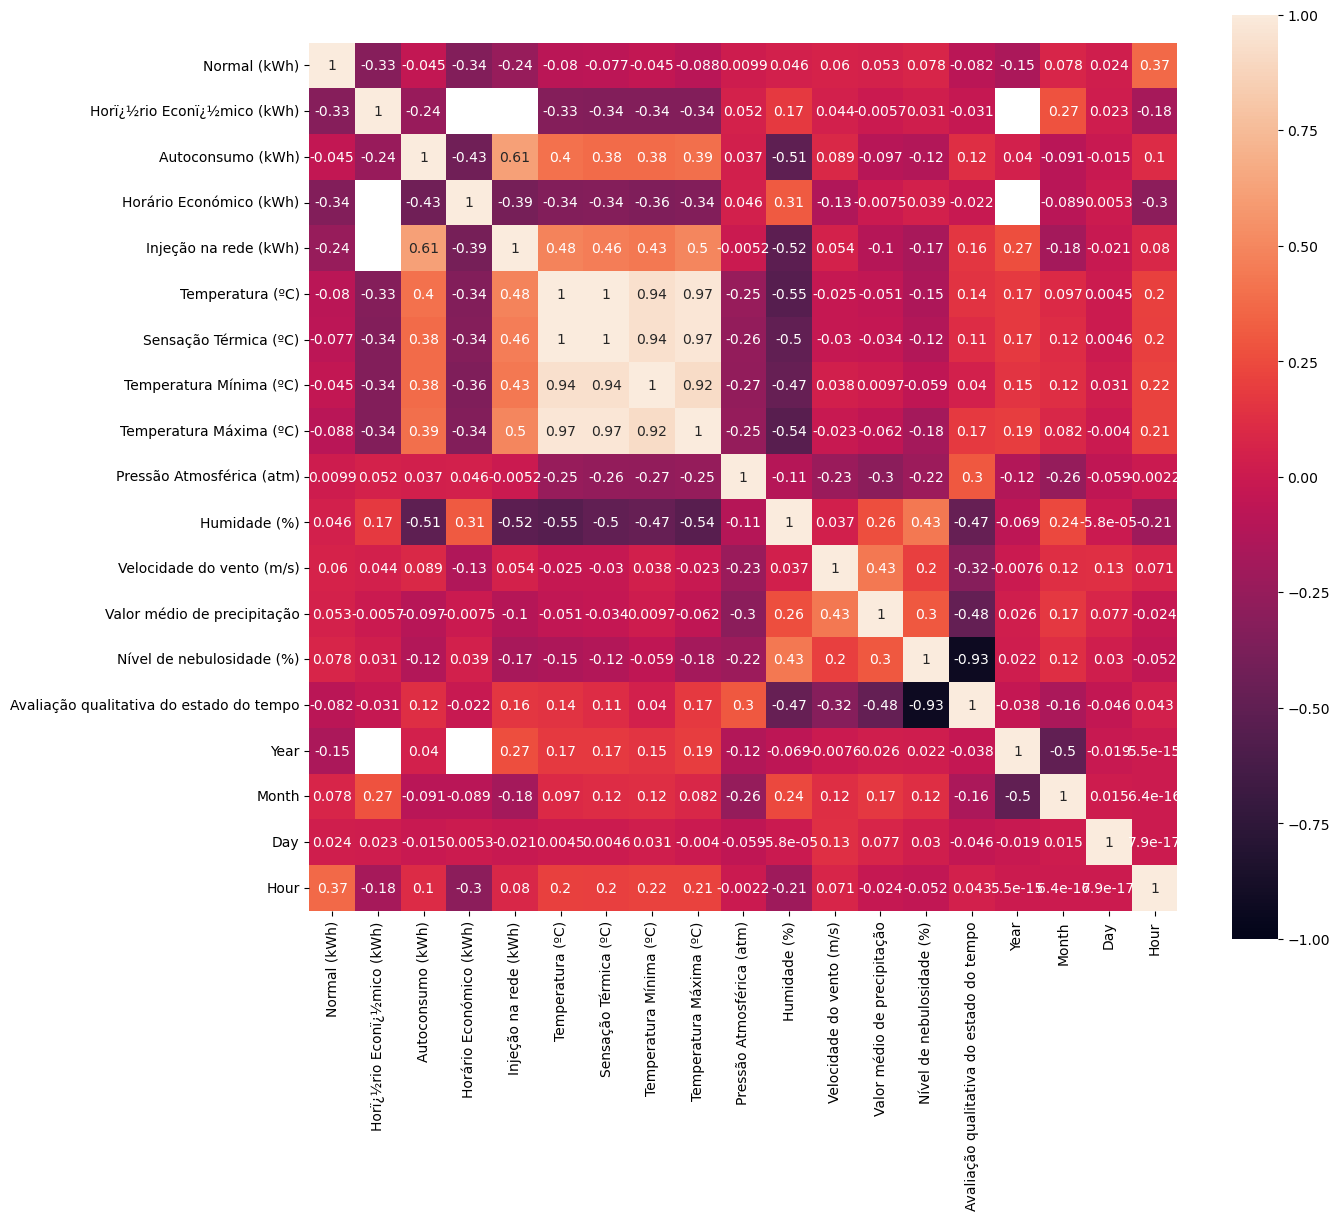

In [125]:
corr_matrix = data.corr(method='pearson', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

### Processamento do dataset de teste

In [126]:
meteo2023.rename(columns={'dt': 'Timestamp','dt_iso':'Data', 'city_name':'Nome da Cidade', 'temp':'Temperatura (ºC)', 'feels_like': 'Sensação Térmica (ºC)', 'temp_min': 'Temperatura Mínima (ºC)', 'temp_max': 'Temperatura Máxima (ºC)', 'pressure': 'Pressão Atmosférica (atm)', 'sea_level': 'Pressão atmosférica no nível do mar (atm)', 'grnd_level': 'Pressão atmosférica na altitude local (atm)', 'humidity': 'Humidade (%)', 'wind_speed': 'Velocidade do vento (m/s)', 'rain_1h': 'Valor médio de precipitação', 'clouds_all': 'Nível de nebulosidade (%)', 'weather_description': 'Avaliação qualitativa do estado do tempo'}, inplace=True)

meteo2023['Data'] = pd.to_datetime(meteo2023['Data'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC

energia2023['Data'] = pd.to_datetime(energia2023.apply(lambda row: f"{row['Data']} {row['Hora']}", axis=1), format='%Y-%m-%d %H', errors='coerce') 
energia2023.drop('Hora', axis=1, inplace=True)

In [127]:
data_test = pd.merge(energia2023, meteo2023, how='inner', on='Data')
data_test1 = pd.merge(energia2023, meteo2023, how='left', on='Data')

difference = data_test1.merge(data_test, how='outer', indicator=True)
difference = difference[difference['_merge'] == 'left_only'].drop(columns='_merge')
difference

,Data,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Timestamp,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
1752,2023-03-15 00:00:00,0.000,0.502,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,2023-03-15 01:00:00,0.000,0.504,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,2023-03-15 02:00:00,0.000,0.494,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1755,2023-03-15 03:00:00,0.000,0.495,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1756,2023-03-15 04:00:00,0.000,0.349,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04 19:00:00,0.953,0.000,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2252,2023-04-04 20:00:00,0.915,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2253,2023-04-04 21:00:00,0.479,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2254,2023-04-04 22:00:00,0.000,0.497,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remoção de Missing Values

<Axes: >

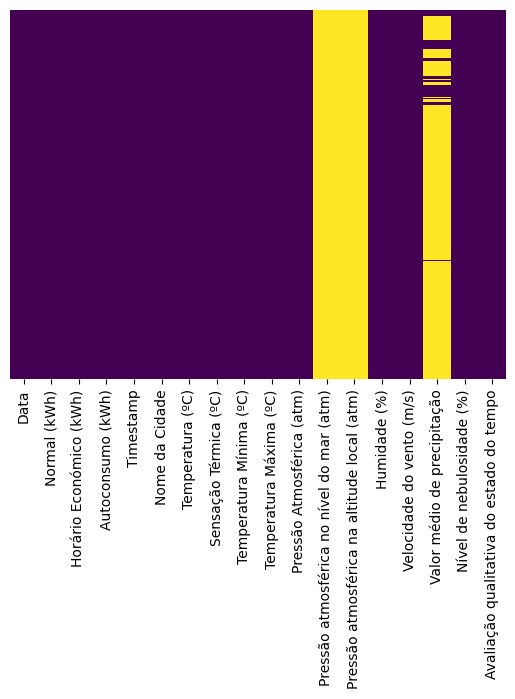

In [128]:
sns.heatmap(data_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [129]:
print(data_test['Pressão atmosférica no nível do mar (atm)'].value_counts())
print(data_test['Pressão atmosférica na altitude local (atm)'].value_counts())
print(data_test['Nome da Cidade'].value_counts())
print(data_test['Timestamp'].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Nome da Cidade
local    1752
Name: count, dtype: int64
Timestamp
1672531200    1
1676721600    1
1676761200    1
1676757600    1
1676754000    1
             ..
1674619200    1
1674615600    1
1674612000    1
1674608400    1
1678834800    1
Name: count, Length: 1752, dtype: int64


In [130]:
data_test.drop(['Pressão atmosférica no nível do mar (atm)', 'Pressão atmosférica na altitude local (atm)','Nome da Cidade','Timestamp'], axis=1, inplace=True)
difference.drop(['Pressão atmosférica no nível do mar (atm)', 'Pressão atmosférica na altitude local (atm)','Nome da Cidade','Timestamp'], axis=1, inplace=True)

<Axes: >

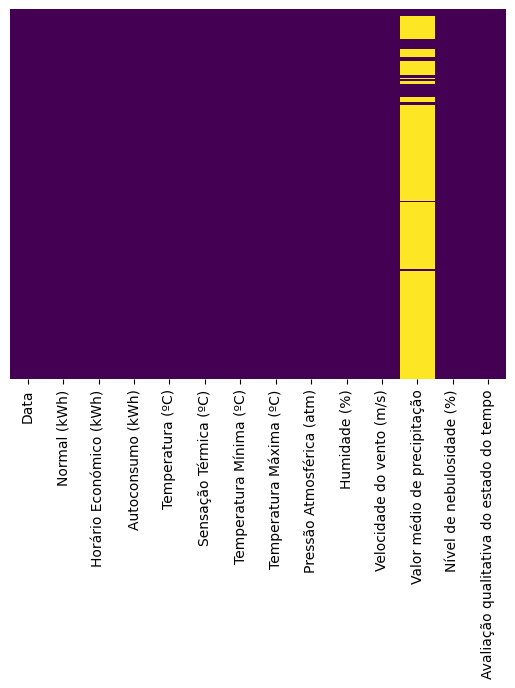

In [131]:
sns.heatmap(data_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [132]:
data_test['Valor médio de precipitação'] = data_test['Valor médio de precipitação'].fillna(0)

In [133]:
data_test['Year'] = data_test['Data'].dt.year
data_test['Month'] = data_test['Data'].dt.month
data_test['Day'] = data_test['Data'].dt.day
data_test['Hour'] = data_test['Data'].dt.hour

data_test.drop(['Data'], axis=1, inplace=True)

difference['Year'] = difference['Data'].dt.year
difference['Month'] = difference['Data'].dt.month
difference['Day'] = difference['Data'].dt.day
difference['Hour'] = difference['Data'].dt.hour

difference.drop(['Data'], axis=1, inplace=True)

In [134]:
mapeamento = {'heavy intensity rain': 0, 'moderate rain': 1, 'few clouds': 2, 'scattered clouds': 3, 'broken clouds': 4,'light rain': 5,'overcast clouds': 6,'sky is clear': 7}

# Substituir os valores no DataFrame
data_test['Avaliação qualitativa do estado do tempo'] = data_test['Avaliação qualitativa do estado do tempo'].replace(mapeamento)

<Axes: >

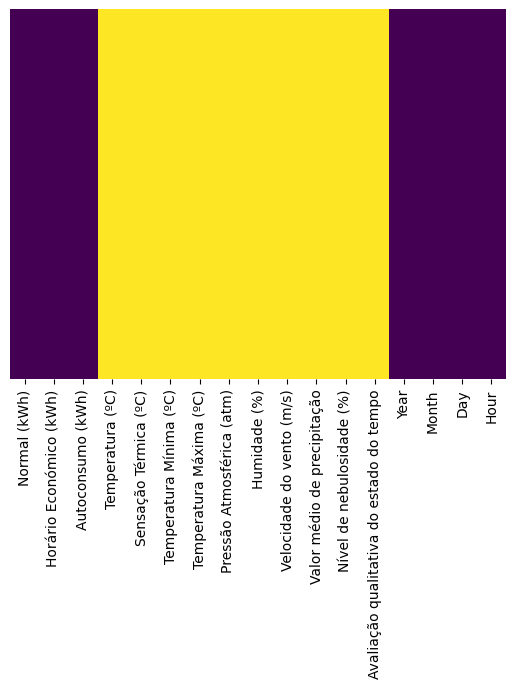

In [135]:
sns.heatmap(difference.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [136]:
features_to_fill = ['Temperatura (ºC)', 
                    'Sensação Térmica (ºC)',
                    'Temperatura Mínima (ºC)',
                    'Temperatura Máxima (ºC)',
                    'Pressão Atmosférica (atm)', 
                    'Humidade (%)', 
                    'Velocidade do vento (m/s)', 
                    'Valor médio de precipitação', 
                    'Nível de nebulosidade (%)',
                    'Avaliação qualitativa do estado do tempo']

for feature in features_to_fill:
    mean = data[feature].median()  # Ou data[feature].median() para mediana
    
    # Preenchendo os valores ausentes em 'data_test' com a média ou mediana
    difference[feature].fillna(mean, inplace=True)

<Axes: >

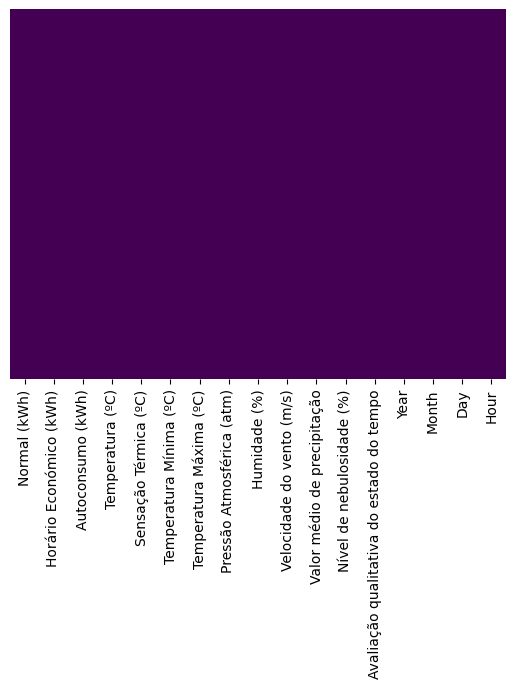

In [137]:
sns.heatmap(difference.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [138]:
data_test = pd.concat([data_test, difference])

In [139]:
data_test

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.467,0.000,12.930,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,1.0,2023,1,1,0
1,0.000,0.577,0.000,13.490,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,1.0,2023,1,1,1
2,0.000,0.346,0.000,13.550,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,1.0,2023,1,1,2
3,0.000,0.270,0.000,13.610,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,1.0,2023,1,1,3
4,0.000,0.252,0.000,13.590,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,1.0,2023,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0.953,0.000,0.012,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,19
2252,0.915,0.000,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,20
2253,0.479,0.000,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,21
2254,0.000,0.497,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,22


### Modelação

### Regressão Logística

In [140]:
import time

X_train = data.drop('Injeção na rede (kWh)', axis=1)  
y_train = data['Injeção na rede (kWh)']
X_test = data_test
X_test

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.467,0.000,12.930,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,1.0,2023,1,1,0
1,0.000,0.577,0.000,13.490,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,1.0,2023,1,1,1
2,0.000,0.346,0.000,13.550,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,1.0,2023,1,1,2
3,0.000,0.270,0.000,13.610,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,1.0,2023,1,1,3
4,0.000,0.252,0.000,13.590,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,1.0,2023,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0.953,0.000,0.012,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,19
2252,0.915,0.000,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,20
2253,0.479,0.000,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,21
2254,0.000,0.497,0.000,15.625,15.23,14.23,16.26,1018.0,81.0,2.40,0.00,60.0,4.0,2023,4,4,22


In [141]:
from sklearn.linear_model import LogisticRegression

### Training with newton-cg solver

In [147]:
X_train

,Normal (kWh),Horï¿½rio Econï¿½mico (kWh),Autoconsumo (kWh),Injeï¿½ï¿½o na rede (kWh),Horário Económico (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.0,0.0,NaN,NaN,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,3,2021,9,29,0
1,0.000,0.0,0.0,NaN,NaN,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,3,2021,9,29,1
2,0.000,0.0,0.0,NaN,NaN,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,3,2021,9,29,2
3,0.000,0.0,0.0,NaN,NaN,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,3,2021,9,29,3
4,0.000,0.0,0.0,NaN,NaN,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,3,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,NaN,0.0,NaN,0.000,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,1,2022,12,31,19
11012,1.327,NaN,0.0,NaN,0.000,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,0,2022,12,31,20
11013,0.757,NaN,0.0,NaN,0.000,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,0,2022,12,31,21
11014,0.000,NaN,0.0,NaN,0.675,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,1,2022,12,31,22


In [143]:
starttime = time.process_time()

logmodel1 = LogisticRegression(random_state=2022, solver='newton-cg')
print(logmodel1)
logmodel1.fit(X_train, y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022, solver='newton-cg')


ValueError: could not convert string to float: 'Low'

In [ ]:
predictions1 = logmodel1.predict(X_test)

### Training with lbfgs solver

In [ ]:
starttime = time.process_time()

logmodel2 = LogisticRegression(random_state=2022, solver='lbfgs')
print(logmodel2)
logmodel2.fit(X_train,y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022)


Time spent: 2.2768989459999602 seconds


/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
predictions2 = logmodel2.predict(X_test)

### Training with liblinear solver



In [ ]:
starttime = time.process_time()

logmodel3 = LogisticRegression(random_state=2022, solver='liblinear')
print(logmodel3)
logmodel3.fit(X_train,y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022, solver='liblinear')
Time spent: 1.2346684340000138 seconds


In [ ]:
predictions3 = logmodel3.predict(X_test)

### SVM (Support Vector Machine) with 10-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

df_feat = cross_val_score(SVC(random_state=2022), X_train, np.ravel(y_train), cv=10)
df_feat

array([0.70598911, 0.70598911, 0.70598911, 0.70598911, 0.70598911,
       0.70598911, 0.70663034, 0.70572207, 0.70572207, 0.70572207])

In [ ]:
X_train = data.drop('Injeção na rede (kWh)', axis=1)  
y_train = data['Injeção na rede (kWh)']

model = SVC(random_state=2022)

model.fit(X_train, np.ravel(y_train))

pred_svm_cv = model.predict(data_test)

### SVM (Support Vector Machine) without Cross Validation

In [ ]:
model = SVC(random_state=2021)

In [ ]:
model.fit(X_train, np.ravel(y_train))

SVC(random_state=2021)

In [ ]:
pred_svm = model.predict(X_test)

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=2021)

In [ ]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2021)

In [ ]:
decision_tree_predictions = dt_model.predict(data_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
estimator_dt = DecisionTreeClassifier(random_state=2021)
grid_dt = GridSearchCV(estimator_dt, param_grid, refit=True, verbose=True)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=True)

In [ ]:
grid_dt_predictions = grid_dt.predict(data_test)

Redes Neuronais

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# Função para construir o modelo
def build_model(optimizer='adam', activation='relu', learning_rate=0.01):
    model = Sequential()
    model.add(Dense(16, input_dim=5, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  
    
    # Compile o modelo
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'sigmoid'],
    'learning_rate': [0.01, 0.1, 0.001]
}

model = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

kf = KFold(n_splits=5, shuffle=True, random_state=2021)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, verbose=1, refit=True)

grid_result = grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_result.best_params_)

predictions_mlp = grid_result.predict(X_test)


/tmp/ipykernel_32005/3717247212.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=0)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_48" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_49" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_50" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_51" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_52" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_53" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_54" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_55" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_56" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_57" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_58" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_59" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_60" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_61" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_62" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_63" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_64" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_65" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_66" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_67" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_68" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_69" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_70" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_71" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_72" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_73" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_74" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_75" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_76" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_77" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_78" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_79" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_80" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_81" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_82" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_83" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_84" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_85" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_86" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_87" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_88" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_89" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_90" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_91" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_92" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_93" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_94" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_95" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_96" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_97" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_98" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_99" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_100" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_101" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_102" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_103" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_104" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_105" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_106" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filenp28no83.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_107" is incompatible with the layer: expected shape=(None, 5), found shape=(None, 17)



### Write the Results


In [ ]:
import pandas as pd

def write_predictions_to_csv(index, predictions, filepath):
    df = pd.DataFrame({'RowId': index, 'Result': predictions})
    df.to_csv(filepath, index=False)

mapeamento = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
predictions = [mapeamento[prediction] for prediction in grid_dt_predictions]

write_predictions_to_csv(data_test.index+1, predictions, 'predictions1.csv')
